### STATISTIC:  fraction


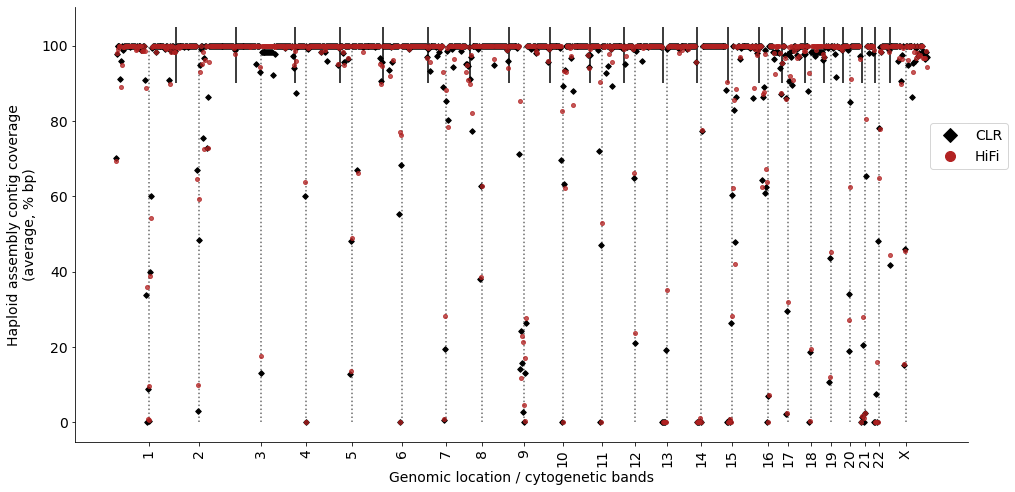

In [2]:
import os
import collections as col
import importlib
import re

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

save_plots = True
print_stats = False

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/figSX_panels/assm_completeness'
out_path = os.path.join(stats_path, pipeline_version, 'figSX_panel_completeness')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))


def extract_region_type(region_name):
    
    if region_name.split('_')[0] in ['Gap', 'Variation', 'Unknown']:
        return region_name.split('_')[0]
    elif region_name[:3] in ['CEN', 'PAR', 'HET']:
        return region_name[:3]
    else:
        raise ValueError('Cannot process: {}'.format(region_name))


def load_coordinates():
    local_paths = [
        '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/20200723_GRCh38_p13_regions.bed',
        '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/20200723_GRCh38_p13_unresolved-issues.bed',
        '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/GRCh38_cytobands.bed',
        '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/GRCh38_segdups.bed'
    ]
    coord_lut = dict()
    for lp in local_paths:
        label = os.path.basename(lp).split('.')[0]
        df = pd.read_csv(lp, sep='\t', usecols=[0, 1, 2, 3], skiprows=1,
                         names=['chrom', 'start', 'end', 'name'])
        coord_lut[label] = df
    return coord_lut


def load_sequence_profiles():
    local_path = '/home/local/work/data/hgsvc/figSX_panels/region_nuc_profiles'
    
    names=[
        'name',
        'GC_frac',
        'AT_frac',
        'count_A',
        'count_C',
        'count_G',
        'count_T',
        'count_N',
        'count_X',
    ]
    
    access_lut = dict()
    for fn in os.listdir(local_path):
        fp = os.path.join(local_path, fn)
        label = fn.split('.')[0].split('_', 3)[3]
        df = pd.read_csv(fp, sep='\t', usecols=[3, 4, 5, 6, 7, 8, 9, 10, 11], skiprows=1,
                         names=names)
        assert (df['count_X'] == 0).all(), 'Unrecognized nucleotide: {}'.format(fn)
        df.drop('count_X', axis=1, inplace=True)
        df['accessible_pct'] = ((df['GC_frac'] + df['AT_frac']) * 100).round(2)
        access_lut[label] = df
    return access_lut


def add_profiles_to_cache(cache_path):
    
    with pd.HDFStore(cache_path, 'a') as hdf:
        for key, value in load_sequence_profiles().items():
            if 'issues' in key:
                store_key = 'issues'
            else:
                store_key = key.rsplit('_', 1)[-1]
            hdf.put(os.path.join('nucprof', store_key), value, format='fixed')
    return


def load_contig_coverages(path, accessibility):

    contig_ovl_header = [
        'chrom',
        'start',
        'end',
        'name',
        'ovl_chrom',
        'ovl_start',
        'ovl_end',
        'coverage'
    ]
    
    per_sample = []
    for overlap_file in os.listdir(path):
        file_path = os.path.join(path, overlap_file)
        df = pd.read_csv(file_path, sep='\t', names=contig_ovl_header,
                         usecols=[
                             'chrom',
                             'start',
                             'end',
                             'name',
                             'coverage'
                         ])
        total_ovl = df.groupby('name')['coverage'].sum()
        df.drop('coverage', axis=1, inplace=True)
        df.drop_duplicates('name', keep='first', inplace=True)
        df = df.merge(total_ovl, on='name')
        df['stat_type'] = 'count'
        df['input_type'] = 'contig'
        
        sample, platform = plot_aux.extract_sample_platform(
            overlap_file.split('_OVL_')[1],
        )
        
        df['sample'] = sample
        df['platform'] = platform
        df['super_pop'] = samples[sample]['super_population']
        df['population'] = samples[sample]['population']
        df['assembly'] = 'HAP'
        if 'h1-un' in overlap_file:
            hap = 10
        elif 'h2-un' in overlap_file:
            hap = 20
        else:
            raise
        df['hap'] = hap
        
        if 'cytobands' in overlap_file:
            df['region_type'] = 'cytoband'
        elif 'segdups' in overlap_file:
            df['region_type'] = 'segdup'
        else:
            df['region_type'] = df['name'].map(extract_region_type)
        
        df2 = df.copy()
        df2['stat_type'] = 'fraction'
        df2['coverage'] = df2['coverage'] / (df2['end'] - df2['start'])
        df2['coverage'] = (df2['coverage'] * 100).round(2)
        
        annotation_file = overlap_file.split('_OVL_')[0]
        nuc_stats = accessibility[annotation_file]
        df3 = df2.copy()
        df3['stat_type'] = 'accessible'
        df3 = df3.merge(nuc_stats, on='name', how='outer')
        # coverage here is still fractional, copied from df2
        df3['coverage'] = 100 - (df3['accessible_pct'] - df3['coverage']).abs().round(2)
        df3.drop([
            'GC_frac',
            'AT_frac',
            'count_A',
            'count_C',
            'count_G',
            'count_T',
            'count_N',
            'accessible_pct'
        ], axis=1, inplace=True)
                
        df = pd.concat([df, df2, df3], axis=0)
        
        index_infos = [
            'chrom',
            'region_type',
            'stat_type',
            'input_type',
            'sample',
            'population',
            'super_pop',
            'platform',
            'assembly',
            'hap'
        ]
        
        # multiindex arrays
        idx_arrays = [df[i] for i in index_infos]
        idx_names = index_infos
        
        df.index = pd.MultiIndex.from_arrays(
            idx_arrays,
            names=idx_names
        )
        df.drop(index_infos, axis=1, inplace=True)
        per_sample.append(df)

    per_sample = pd.concat(per_sample, axis=0)

    return per_sample
     

def load_read_coverages(path, coordinates, accessibility):
    
    read_cov_header = [
        'name',
        'length',
        'coverage',
        'coverage_cumsum',
        'mean0',
        'mean'
    ]
    
    per_sample = []
    for coverage_file in os.listdir(path):
        file_path = os.path.join(path, coverage_file)
        df = pd.read_csv(file_path, sep='\t', names=read_cov_header)
        
        annotation_file, read_file = coverage_file.split('_AVG_')
        
        cov_count = df[['name', 'coverage']].copy()
        cov_count['stat_type'] = 'count'
        
        cov_frac = df[['name', 'length', 'coverage']].copy()
        cov_frac['stat_type'] = 'accessible'
        cov_frac['coverage'] = cov_frac['coverage'] / cov_frac['length']
        cov_frac['coverage'] = (cov_frac['coverage'] * 100).round(2)
        cov_frac.drop('length', axis=1, inplace=True)
        
        nuc_stats = accessibility[annotation_file]
        cov_access = cov_frac.copy()
        cov_access['stat_type'] = 'accessible'
        cov_access = cov_access.merge(nuc_stats, on='name', how='outer')
        cov_access['coverage'] = 100 - (cov_access['accessible_pct'] - cov_access['coverage']).abs().round(2)
        cov_access.drop([
            'GC_frac',
            'AT_frac',
            'count_A',
            'count_C',
            'count_G',
            'count_T',
            'count_N',
            'accessible_pct'
        ], axis=1, inplace=True)
        
        cov_mean0 = df[['name', 'mean0']].copy()
        cov_mean0['stat_type'] = 'average'
        cov_mean0.columns = ['name', 'coverage', 'stat_type']
        
        cov_mean = df[['name', 'mean']].copy()
        cov_mean['stat_type'] = 'nz_avg'
        cov_mean.columns = ['name', 'coverage', 'stat_type']
        
        df = pd.concat([cov_count, cov_frac, cov_access, cov_mean0, cov_mean], axis=0)
        
        coords = coordinates[annotation_file]
                
        sample, platform = plot_aux.extract_sample_platform(read_file)
        
        df['input_type'] = 'read'
        df['sample'] = sample
        df['platform'] = platform
        df['super_pop'] = samples[sample]['super_population']
        df['population'] = samples[sample]['population']
        df['assembly'] = 'HAP'
        if 'h1.tab' in coverage_file:
            hap = 1
        elif 'h2.tab' in coverage_file:
            hap = 2
        elif '.un.tab' in coverage_file:
            hap = 0
        elif 'h1-un.tab' in coverage_file:
            hap = 10
        elif 'h2-un.tab' in coverage_file:
            hap = 20
        else:
            raise

        df['hap'] = hap
        if 'cytobands' in coverage_file:
            df['region_type'] = 'cytoband'
        elif 'segdups' in coverage_file:
            df['region_type'] = 'segdup'
        else:
            df['region_type'] = df['name'].map(extract_region_type)
        
        df = df.merge(coords, on='name', how='inner')
        
        index_infos = [
            'chrom',
            'region_type',
            'stat_type',
            'input_type',
            'sample',
            'population',
            'super_pop',
            'platform',
            'assembly',
            'hap'
        ]
        
        # multiindex arrays
        idx_arrays = [df[i] for i in index_infos]
        idx_names = index_infos
        
        df.index = pd.MultiIndex.from_arrays(
            idx_arrays,
            names=idx_names
        )
        df.drop(index_infos, axis=1, inplace=True)
        per_sample.append(df)

    per_sample = pd.concat(per_sample, axis=0)

    return per_sample


if not os.path.isfile(cache_file):
    
    contig_stats = load_contig_coverages(
        os.path.join(stats_path, 'contig_coverage'),
        load_sequence_profiles()
    )
    read_stats = load_read_coverages(
        os.path.join(stats_path, 'hap_read_coverage'),
        load_coordinates(),
        load_sequence_profiles()
    )
    
    df = pd.concat([contig_stats, read_stats], axis=0)
    
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    add_profiles_to_cache(cache_file)
    
df = pd.read_hdf(cache_file, 'cache')
     
main_chroms = ['chr' + str(i) for i in range(1, 23)]
main_chroms.append('chrX')
df = df.loc[df.index.isin(main_chroms, level='chrom'), :]

missing=False

def plot_contig_coverage(sample_stats, stat_type):
    
    clr_assm = sample_stats.xs(
        ['CLR', 'contig', 'cytoband', stat_type],
        level=['platform', 'input_type', 'region_type', 'stat_type'],
        drop_level=True
    ).copy()
    clr_cov = pd.DataFrame(clr_assm.groupby(['chrom', 'start', 'name'])['coverage'].mean())
    clr_cov['sort_order'] = clr_cov.index.get_level_values('chrom').map(lambda x: 23 if x == 'chrX' else int(x.strip('chr')))
    clr_cov.sort_values(['sort_order', 'start'], ascending=True, inplace=True)
    #clr_std = clr_assm.groupby(['chrom', 'start', 'name'])['coverage'].std()
                
    hifi_assm = sample_stats.xs(
        ['HiFi', 'contig', 'cytoband', stat_type],
        level=['platform', 'input_type', 'region_type', 'stat_type'],
        drop_level=True
    )
    hifi_cov = pd.DataFrame(hifi_assm.groupby(['chrom', 'start', 'name'])['coverage'].mean())
    hifi_cov['sort_order'] = hifi_cov.index.get_level_values('chrom').map(lambda x: 23 if x == 'chrX' else int(x.strip('chr')))
    hifi_cov.sort_values(['sort_order', 'start'], ascending=True, inplace=True)
    
    #hifi_std = hifi_assm.groupby(['chrom', 'start', 'name'])['coverage'].std()

    
    fig, axis = plt.subplots(figsize=(16,8))
    
    x_vals_clr = np.array(range(0, clr_cov.shape[0]*2, 2), dtype=np.float16)
    x_vals_hifi = x_vals_clr + 1

    axis.errorbar(
        x_vals_clr,
        clr_cov['coverage'].values,
        yerr=None, #clr_std.values,
        marker=prop('CLR_marker'),
        color=plot_aux.get_platform_color('CLR'),
        linestyle='',
        markersize=4
    )
    
    axis.errorbar(
        x_vals_hifi,
        hifi_cov['coverage'].values,
        yerr=None,#hifi_std.values,
        marker=prop('HiFi_marker'),
        color=plot_aux.get_platform_color('HiFi'),
        linestyle='',
        markersize=4,
        alpha=0.75
    )
    
    x_ticks = []
    x_ticklabels = []
    vlines_boundary = []
    vlines_cen = []
    cytogenic_bands = clr_cov.index.get_level_values('name')
    last_chrom = cytogenic_bands[0].split('p')[0]
    last_arm = 'p'
    extract = re.compile('(?P<chrom>chr[0-9X]+)(?P<arm>(p|q))(?P<segment>[0-9\.]+)')
    for x_val, band_id in zip(x_vals_hifi, cytogenic_bands):
        mobj = extract.match(band_id)
        if mobj is None:
            raise ValueError(band_id)
        chrom = mobj.group('chrom')
        arm = mobj.group('arm')
        if chrom != last_chrom:
            vlines_boundary.append(x_val + 0.5)
            last_chrom = chrom
            last_arm = 'p'
            continue
        elif arm != last_arm:
            x_ticks.append(x_val + 0.5)
            x_ticklabels.append(chrom)
            vlines_cen.append(x_val + 0.5)
            last_arm = arm
        else:
            pass
    
    axis.vlines(vlines_boundary, 90, 105, color='black', linestyle='solid', zorder=0)
    axis.vlines(vlines_cen, 0, 100, color='dimgrey', linestyle='dotted', zorder=0)
    
    axis.set_xticks(x_ticks)
    axis.set_xticklabels([x.strip('chr') for x in x_ticklabels], rotation=90)

    axis.set_xlabel(
        'Genomic location / cytogenetic bands',
        fontsize=prop('fontsize_legend')
    )
    axis.set_ylabel(
        'Haploid assembly contig coverage\n(average, % bp)',
        fontsize=prop('fontsize_legend')
    )
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
        
    # build custom legend
    custom_lines = [
        lines.Line2D(
            [0], [0],
            color=plot_aux.get_platform_color('CLR'),
            markersize=prop('legend_marker_size'),
            marker=prop('CLR_marker'),
            ls='None',
            label='CLR',
        ),
        lines.Line2D(
            [0], [0],
            color=plot_aux.get_platform_color('HiFi'),
            markersize=prop('legend_marker_size'),
            marker=prop('HiFi_marker'),
            ls='None',
            label='HiFi',
        )   
    ]
    
    lgd = axis.legend(
        handles=custom_lines,
        prop={'size': prop('fontsize_legend')},
        bbox_to_anchor=(0.95, 0.75)
    )

    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.5, 0.85)
    
    extra_artists = [lgd]
    
    return fig, extra_artists

# fraction: % covered bp, not normalizing for N
# accessible: % covered bp, normalizing for N

for stat_type in ['fraction', 'accessible']:
    if stat_type == 'accessible':
        # manuscript version: fraction
        continue
    print('### STATISTIC: ', stat_type)
    if save_plots:
        fig, exart = plot_contig_coverage(df, stat_type)

        low_res_dpi = prop('dpi_low_res')
        fig.savefig(
            out_path + '_' + stat_type + '.{}dpi.png'.format(low_res_dpi),
            dpi=low_res_dpi,
            bbox_inches='tight',
            extra_artists=exart
        )
        
        norm_res_dpi = prop('dpi_norm_res')
        fig.savefig(
            out_path + '_' + stat_type + '.{}dpi.png'.format(norm_res_dpi),
            dpi=norm_res_dpi,
            bbox_inches='tight',
            extra_artists=exart
        )
        fig.savefig(out_path + '_' + stat_type + '.svg', bbox_inches='tight', extra_artists=exart)

    if print_stats:
        region_select = [
            'CEN',
            'Gap',
            'segdup'
        ]
        
        for rs in region_select:
            if rs == 'Gap':
                subsets = [
                    df.xs(
                        ['contig', rs, stat_type],
                        level=['input_type', 'region_type', 'stat_type']
                    ),
                    df.xs(
                        ['contig', 'Unknown', stat_type],
                        level=['input_type', 'region_type', 'stat_type']
                    )
                ]
                subsets = pd.concat(subsets, ignore_index=False, axis=0)
                print('---> Region: {}'.format(rs))
                print('=== ALL stats summary')
                print(subsets['coverage'].describe())

                clr_stats = subsets.xs(
                    ['CLR'],
                    level=['platform']
                )
                print('=== CLR stats')
                print(clr_stats['coverage'].describe())

                hifi_stats = subsets.xs(
                    ['HiFi'],
                    level=['platform']
                )
                print('=== HiFi stats')
                print(hifi_stats['coverage'].describe())

            else:
                print('---> Region: {}'.format(rs))
                print('=== ALL stats summary')
                all_stats = df.xs(
                    ['contig', rs, stat_type],
                    level=['input_type', 'region_type', 'stat_type']
                )
                print(all_stats['coverage'].describe())

                clr_stats = df.xs(
                    ['CLR', 'contig', rs, stat_type],
                    level=['platform', 'input_type', 'region_type', 'stat_type']
                )
                print('=== CLR stats')
                print(clr_stats['coverage'].describe())

                hifi_stats = df.xs(
                    ['HiFi', 'contig', rs, stat_type],
                    level=['platform', 'input_type', 'region_type', 'stat_type']
                )
                print('=== HiFi stats')
                print(hifi_stats['coverage'].describe())
